# Multi-Layer Perceptron

The baseline test described in the paper is that using an MLP. On the dataset, it achieved a 69.7% measured in AUC.

In [4]:
import math
from typing import Callable, List

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

from tinygrad import Tensor, nn
from tinygrad.engine.lazy import LazyBuffer
from tinygrad.tensor import Function


## Creating the Dataset

The methodology in the paper prescribes a 65/15/20 train/val/test set with 5 cross validation splits. The data is found in `ticdata2000.txt` and the pair of `ticeval2000.txt` and `tictgts2000.txt` (tic=The Insurance Company, eval=Evaluation/Test, tgts=Targets).


In [5]:
def load_data(file_path: str, delimiter: str = "\t", has_target: bool = True):
    data = np.loadtxt(file_path, delimiter=delimiter)
    if has_target:
        X, y = data[:, :-1], data[:, -1]
        return X, y
    return data


def normalize_nonbinary_columns(X: np.ndarray) -> np.ndarray:
    for i in range(X.shape[1]):
        unique_vals = np.unique(X[:, i])
        if not np.array_equal(unique_vals, [0, 1]):
            X[:, i] = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
    return X


In [6]:
with open("dataset/names.txt", "r") as file:
    feature_names = [line.strip() for line in file.readlines()]

X_train, y_train = load_data("dataset/ticdata2000.txt")
X_train = normalize_nonbinary_columns(X_train)

X_test = load_data("dataset/ticeval2000.txt", has_target=False)
X_test = normalize_nonbinary_columns(X_test)
y_test = np.loadtxt("dataset/tictgts2000.txt", delimiter="\t")

X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))

num_samples = X_combined.shape[0]
indices = np.random.permutation(num_samples)
X_shuffled = X_combined[indices]
y_shuffled = y_combined[indices]

train_end = int(0.65 * num_samples)
val_end = int((0.65 + 0.15) * num_samples)

X_train_new = X_shuffled[:train_end]
y_train_new = y_shuffled[:train_end]
X_val_new = X_shuffled[train_end:val_end]
y_val_new = y_shuffled[train_end:val_end]
X_test_new = X_shuffled[val_end:]
y_test_new = y_shuffled[val_end:]


## Defining the Model

- 2 hidden layers:
  - $l$ is the input size
  - 1<sup>st</sup> hidden layer had $m_1l$ units where $1\le m_1\le 8$.
  - 2<sup>nd</sup> hidden layer had $m_2l$ units where $1\le m_2\le 3$.
- SELU Activation Function.
- Batch Normalization after each layer

In [7]:
# https://github.com/pytorch/pytorch/blob/96aaa311c0251d24decb9dc5da4957b7c590af6f/torch/nn/modules/activation.py#L507
class Selu(Function):
    _alpha: float = 1.6732632423543772848170429916717
    _lambda: float = 1.0507009873554804934193349852946

    def forward(self, x: LazyBuffer) -> LazyBuffer:
        alpha_buf = x.const_like(self._alpha)
        lambda_buf = x.const_like(self._lambda)
        self.ret = lambda_buf * LazyBuffer.where(
            x >= 0, x, alpha_buf * ((x * (1 / math.log(2))).exp2() - 1)
        )
        return self.ret

    def backward(self, grad_output: LazyBuffer) -> LazyBuffer:
        alpha_buf = self.ret.const_like(self._alpha)
        lambda_buf = self.ret.const_like(self._lambda)
        dx = LazyBuffer.where(
            self.ret >= 0,
            lambda_buf,
            lambda_buf * alpha_buf * (self.ret * (1 / math.log(2))).exp2(),
        )
        return dx * grad_output


In [8]:
class MLP:
    def __init__(self, l: int, m1: int = 4, m2: int = 2) -> None:
        self.layers: List[Callable[[Tensor], Tensor]] = [
            nn.Linear(l, m1 * l),
            nn.BatchNorm(m1 * l),
            Selu.apply,
            nn.Linear(m1 * l, m2 * l),
            nn.BatchNorm(m2 * l),
            Selu.apply,
            nn.Linear(m2 * l, 1),
            Tensor.sigmoid,
        ]

    def __call__(self, x: Tensor) -> Tensor:
        return x.sequential(self.layers)


## Training the Model

- Evaluation metric was Area under the Curve (AUC).
- Cross Entropy Loss.
- AdamW optimizer.
- Constant Learning Rate (What value?).
- Trained with early stopping based on the performance of validation set.
  - Stopping patience (# of epochs) was 15.

In [9]:
model = MLP(l=X_train_new.shape[1])
optim = nn.optim.AdamW(nn.state.get_parameters(model))  # Try adjusting the learning rate

def early_stop(losses: List[float], patience: int) -> bool:
    if len(losses) < patience:
        return False
    best_loss = min(losses)
    return all(loss >= best_loss for loss in losses[-patience:])

@Tensor.train()
def train_step() -> Tensor:
    optim.zero_grad()
    
    samples = np.random.randint(0, X_train_new.shape[0], 128)
    X_batch = Tensor(X_train_new[samples], dtype="float32")
    y_batch = Tensor(y_train_new[samples], dtype="float32")

    loss = model(X_batch).cross_entropy(y_batch).backward()
    optim.step()

    return loss

@Tensor.test()
def get_cv_auc() -> float:
    y_pred = model(Tensor(X_val_new, dtype="float32"))
    auc = roc_auc_score(y_val_new, y_pred.numpy())
    return auc

val_losses: List[float] = []
n_epochs: int = 0
while n_epochs < 1000:
    loss = train_step()
    cv_auc = get_cv_auc()
    val_losses.append(cv_auc)
    
    if early_stop(val_losses, patience=15):
        print("Early stopping triggered.")
        break
    
    n_epochs += 1

print("Training complete!")

Early stopping triggered.
Training complete!


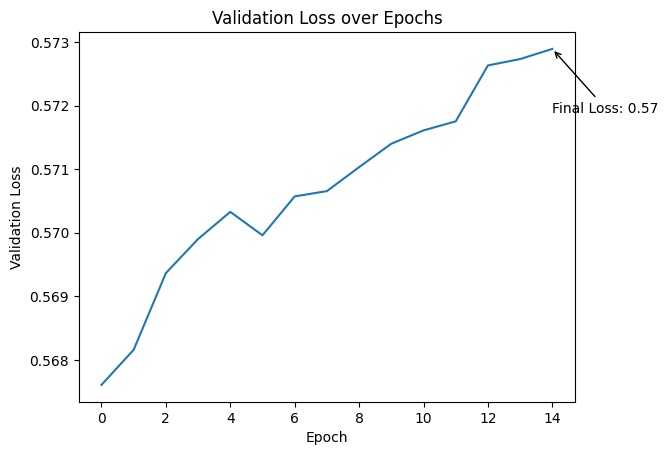

In [10]:
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs")

final_epoch = len(val_losses) - 1
final_loss = val_losses[-1]
plt.annotate(
    f"Final Loss: {final_loss:.2f}", 
    xy=(final_epoch, final_loss), 
    xytext=(final_epoch, final_loss - 0.001),
    arrowprops=dict(arrowstyle="->", color="black")
)

plt.show()

In [17]:
Tensor.training = False
y_test_preds = model(Tensor(X_test_new))
print(f"AUC on Test Set: {100 * roc_auc_score(y_test_new, y_test_preds.numpy()):.2f}%")

AUC on Test Set: 51.56%
